# First Things First

Welcome to our very first introduction to TensorFox, a program made to deal with 3-D tensor, with focus on the CPD (Canonical Polyadic Decomposition). In order to have everything working properly, all files of TensorFox must be in the same folder of your program. Another option is to add all modules to your Python path, if more convenient. To use TensorFox at full capability, you will need the following modules:

- numpy

- scipy

- time

- matplotlib

- numba

- cython

Also make sure you have Numpy is using a nice version of BLAS. That is all! If no errors occurred, TensorFox is read to go! Let's start importing TensorFox and another necessary modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import TensorFox as tf

# Creating Tensors and Getting Information 

Let's create a little tensor T just to see how TensorFox works. It is important to notice that TensorFox only works with tensors as 3-D numpy arrays. 

Our convention is that $T[i,j,k]$ refers to the $i$-th row, $j$-column and $k$-section (frontal slice) of $T$. For instance, consider the tensor defined by $T[i,j,k] = i+j+k$ for $i,j,k = 0,1$. This tensor should be seen as

$$T = \left\{ \left[
\begin{array}{cc}
    0 & 1\\
    1 & 2
\end{array}
\right], \quad
\left[
\begin{array}{cc}
    1 & 2\\
    2 & 3
\end{array}
\right] \right\},$$
where each matrix is a frontal slice of $T$. 

Since Numpy's convention is different from ours, we have a special command to print $T$ by slices. This is the command **showtens**.

In [2]:
# Create and print the tensor, which is 2 x 2 x 2.
T = np.zeros((2,2,2))
for i in range(0,2):
    for j in range(0,2):
        for k in range(0,2):
            T[i,j,k] = i+j+k
            
tf.showtens(T)

[[0. 1.]
 [1. 2.]]

[[1. 2.]
 [2. 3.]]



There are lots of questions we can make about a given tensor: what are its maximum and minimum entries, its dimensions, its condition number, its rank and multirank, etc.

Even in this case we can't know all these answers in advance. The function **infotens** tries to compute all these informations for us. This function is useful for small tensors, but remember that finding the rank is a NP-hard task, so don't abuse. 

In [3]:
# Let's see some information about T.
tf.infotens(T)

T is a tensor of dimensions 2 x 2 x 2

|T| = 4.898979485566356

max(T) = 3.0

min(T) = 0.0

1 <= rank(T) <= 4

multirank(T) = 2 , 2 , 2

Start searching for rank
-------------------------------------------------------------------
r = 1  (stops in r = 4  or less)
r = 2  (stops in r = 4  or less)
r = 3  (stops in r = 4  or less)
Estimated rank(T) = 2
|T - T_approx|/|T| = 2.2288621390821184e-05



# Computing the CPD

Now let's turn to the most important tool of TensorFox, the computation of the CPD. As the previous function hinted, $T$ should have rank 2 (but don't believe blindly in this function). We can compute the corresponding CPD with the function **cpd**.

In [4]:
# Compute the CPD of T, assuming T has rank 2.
r = 2
Lambda, X, Y, Z, T_approx, rel_err, step_sizes_trunc, step_sizes_ref, errors_trunc, errors_ref = tf.cpd(T, r)

# Show the CPD computed. 
print('Lambda =\n',Lambda)
print()
print('X =\n', X)
print()
print('Y =\n', Y)
print()
print('Z =\n', Z)
print()

# Show the coordinate representation of this CPD.
print('T_approx =')
tf.showtens(T_approx)

# Show relative error of this approximation.
print('|T - T_approx|/|T| =',rel_err)

Lambda =
 [78.38158409 82.62422486]

X =
 [[-0.71337422  0.70094847]
 [-0.70078329  0.71321191]]

Y =
 [[-0.71337422 -0.70094848]
 [-0.70078329 -0.71321191]]

Z =
 [[-0.71337422 -0.70094848]
 [-0.70078329 -0.71321191]]

T_approx =
[[-3.85656988e-05  1.00003860e+00]
 [ 1.00003860e+00  1.99996140e+00]]

[[1.0000386  1.9999614 ]
 [1.9999614  3.00003867]]

|T - T_approx|/|T| = 2.2288621390821184e-05


This solution means we can write the CPD of $T$ as

$$T \approx \small 78.3815 \cdot 
\left[
\begin{array}{c}
    -0.71337422\\
    -0.70078329
\end{array}
\right]
\otimes
\left[
\begin{array}{c}
    -0.71337422\\
    -0.70078329
\end{array}
\right]
\otimes
\left[
\begin{array}{c}
    -0.71337422\\
    -0.70078329
\end{array}
\right] 
+ 82.6242 \cdot
\left[
\begin{array}{c}
    0.70094847\\
    0.71321191
\end{array}
\right]
\otimes
\left[
\begin{array}{c}
    -0.70094848\\
    -0.71321191
\end{array}
\right]
\otimes
\left[
\begin{array}{c}
    -0.70094848\\
    -0.71321191
\end{array}
\right].$$

Note that all vectors have Euclidean norm equal to 1. Their magnitudes are aggregate in the $\Lambda$ factors.

The outputs **step_sizes_trunc, step_sizes_ref, errors_trunc, errors_ref** need a more detailed explanation. When we compute the CPD, there are two stages: the *truncation stage* and the *refinement stage*. The truncation stage computes the CPD of a tensor close to $T$ in a low dimensional space. After that we compute the actual CPD of $T$. The reason for doing this is very simple: computation in low dimensional spaces are faster, so we try to make most of them in these low dimensional spaces. We only "go back" when there is nothing more to do in low dimensional. 

Note that we have to go back at some point, since the low dimension was only possible due to a truncation of the tensor. We try to truncate in order to have a tensor as close as possible to $T$ and with low dimension as possible. This trade off *dimensional x distance* is worked with the parameter **energy** which we discuss later. For now let's accept that the default of the program is good enough. 

Below we show a plot of **step_sizes_trunc, step_sizes_ref** arrays. They represent the size of each step taken in the iterative process. Ideally, we want to take larger steps at the beggining (when the current tensor is far from to the objective tensor) and smaller steps at the final (when the current tensor is closer to the objective tensor). 

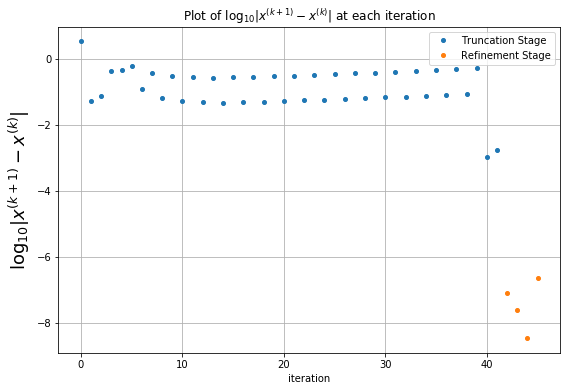

In [5]:
# Plot the step sizes of the iterations.
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 9
fig_size[1] = 6

sst = step_sizes_trunc.shape[0]
ssr = step_sizes_ref.shape[0]
et = errors_trunc.shape[0]
er = errors_ref.shape[0]

plt.plot(np.arange(0,sst), np.log10(step_sizes_trunc), 'o', markersize=4, label='Truncation Stage')
plt.plot(np.arange(sst,sst+ssr), np.log10(step_sizes_ref), 'o', markersize=4, label='Refinement Stage')
plt.title(r'Plot of $\log_{10} \|x^{(k+1)} - x^{(k)} \|$ at each iteration', fontsize=12)
plt.xlabel('iteration')
plt.ylabel(r'$\log_{10} \|x^{(k+1)} - x^{(k)} \|$', fontsize=18)
plt.grid()
plt.legend()
plt.show()

With respect to the plot of the errors, we should expect convergence at the final of the truncation stage an then a jump to a worse error. This is because the point computed in the truncation stage will be projected in the original space, but this projection, althought close to the objective tensor, it may not be as close as it was in the previous stage.

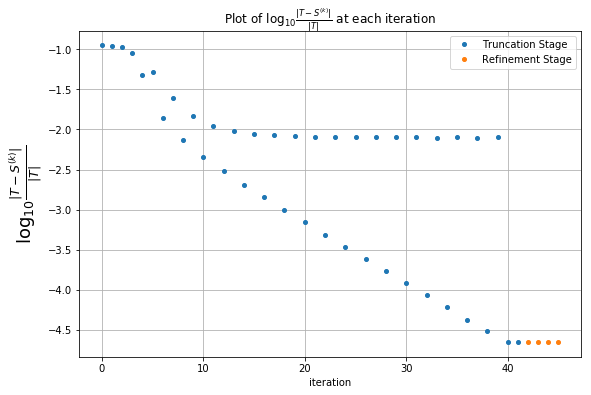

In [6]:
# Plot the relative error of the iterations. Since the output errors of the cpd are absolute errors,
# we mist divide them by the norm of T.
Tsize = np.linalg.norm(T)

plt.plot(np.arange(0,et), np.log10(1/Tsize*errors_trunc), 'o', markersize=4, label='Truncation Stage')
plt.plot(np.arange(et,et+er), np.log10(1/Tsize*errors_ref), 'o', markersize=4, label='Refinement Stage')
plt.title(r'Plot of $\log_{10} \frac{\|T - S^{(k)}\|}{|T|}$ at each iteration', fontsize=12)
plt.xlabel('iteration')
plt.ylabel(r'$\log_{10} \frac{\|T - S^{(k)}\|}{|T|}$', fontsize=18)
plt.grid()
plt.legend()
plt.show()